In [50]:
import drawing
import imp
imp.reload(drawing)

<module 'drawing' from '/u/home/lyrebird_code/handwriting_synthesis/drawing.py'>

In [2]:
import numpy as np

import os

import torch

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(device)


cuda:1


In [3]:
data_dir = "data"
data = [np.load(os.path.join(data_dir, '{}.npy'.format(i))) for i in ['x', 'x_len', 'c', 'c_len', 'w_id']]
strokes = data[0]
stroke_lens = data[1]
strings = data[2]
string_lens = data[3]
w_id = data[4]


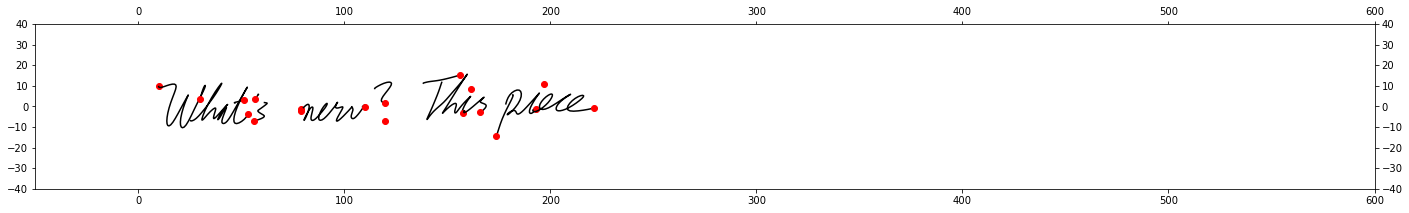

In [4]:
drawing.draw(data[0][0])

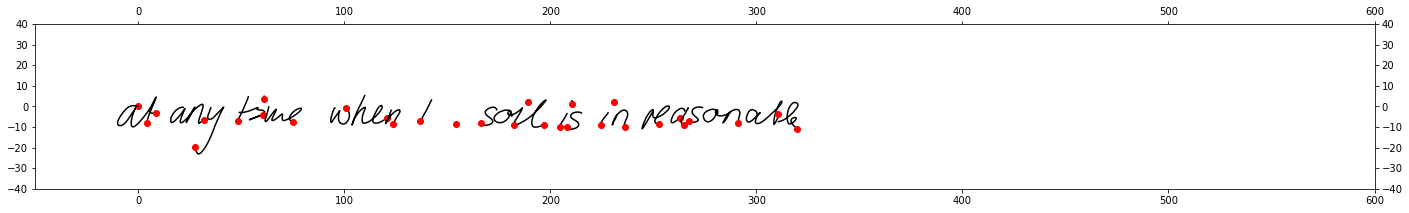

tensor([2915])
864
at any time when the soil is in reasonable


array([[ 0.        ,  0.        ,  1.        ],
       [-0.10438664,  0.02670356,  0.        ],
       [-0.23790441,  0.0631175 ,  0.        ],
       [-0.46367085,  0.09710384,  0.        ],
       [-0.73313403,  0.07040029,  0.        ]], dtype=float32)

In [5]:
index = torch.randint(strokes.shape[0], (1,))
text = drawing.decode_ascii(strings[index])
drawing.draw(strokes[index], align_strokes=False, denoise_strokes=False)
print(index)
print(stroke_lens[index])
print(text)
strokes[index][:5]

In [6]:
import torch 
from torch import tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [7]:
class HandwritingDataset(Dataset):
    def __init__(self, strokes, stroke_lengths):
        self.strokes = strokes
        self.stroke_lengths = stroke_lengths
        
    def __len__(self):
        return self.strokes.shape[0]
    
    def __getitem__(self, idx):
        return self.strokes[idx], self.stroke_lengths[idx]
    
train_dataset = HandwritingDataset(strokes[:10000], stroke_lens[:10000])
test_dataset = HandwritingDataset(strokes[10000:], stroke_lens[10000:])

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=1)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=1)

In [8]:
next(iter(train_dataloader))[0].shape

torch.Size([1, 1200, 3])

In [9]:
len(train_dataloader)
len(test_dataloader)

10000

1911

In [10]:
!pwd

/u/home/lyrebird_code/handwriting_synthesis


In [11]:
device

'cuda:1'

n_iter: 0 of 100000, loss: 3.36615283203125, timeElapsed: 1.9271223545074463
n_iter: 500 of 100000, loss: 1866.282509338379, timeElapsed: 60.051838874816895
n_iter: 1000 of 100000, loss: 1628.1924251708983, timeElapsed: 120.63370442390442
n_iter: 1500 of 100000, loss: 1463.8006382141114, timeElapsed: 180.87356162071228
n_iter: 2000 of 100000, loss: 1295.5206123046876, timeElapsed: 241.15594100952148
n_iter: 2500 of 100000, loss: 1094.4187317199708, timeElapsed: 301.6891233921051
n_iter: 3000 of 100000, loss: 870.9145923156739, timeElapsed: 361.40342354774475
n_iter: 3500 of 100000, loss: 603.0717118835449, timeElapsed: 421.25619196891785
n_iter: 4000 of 100000, loss: 418.6461867713928, timeElapsed: 482.158979177475
n_iter: 4500 of 100000, loss: 249.58763041305542, timeElapsed: 543.6380832195282
n_iter: 5000 of 100000, loss: 117.98100008392333, timeElapsed: 602.5597574710846
n_iter: 5500 of 100000, loss: 9.09068438911438, timeElapsed: 662.3383989334106
n_iter: 6000 of 100000, loss: -126

n_iter: 50000 of 100000, loss: -877.6807029418945, timeElapsed: 6030.89462852478
n_iter: 50500 of 100000, loss: -863.2845894165039, timeElapsed: 6090.37529706955
n_iter: 51000 of 100000, loss: -890.2975085477829, timeElapsed: 6151.348526716232
n_iter: 51500 of 100000, loss: -869.4305024414062, timeElapsed: 6211.4531686306
n_iter: 52000 of 100000, loss: -893.4259063034058, timeElapsed: 6273.041618585587
n_iter: 52500 of 100000, loss: -888.752786643982, timeElapsed: 6333.7153561115265
n_iter: 53000 of 100000, loss: -899.2414728355408, timeElapsed: 6395.087654352188
n_iter: 53500 of 100000, loss: -857.3396501617432, timeElapsed: 6454.414187908173
n_iter: 54000 of 100000, loss: -826.9846292304993, timeElapsed: 6513.3529942035675
n_iter: 54500 of 100000, loss: -861.0304797916413, timeElapsed: 6572.4817616939545
n_iter: 55000 of 100000, loss: -877.1229091758728, timeElapsed: 6632.512109518051
n_iter: 55500 of 100000, loss: -921.5819348373414, timeElapsed: 6693.560324192047
n_iter: 56000 of 1

<Figure size 432x288 with 0 Axes>

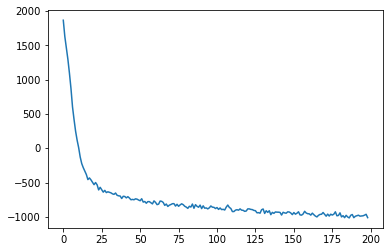

In [12]:
class HandWritingPredictionWithLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_mixtures):
        super(HandWritingPredictionWithLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_mixtures = num_mixtures
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(3*hidden_size, 6*num_mixtures+1)
        
    def forward(self, x, h0, c0):
        out1, _ = self.lstm1(x, (h0, c0))
        out2, _ = self.lstm2(torch.cat((x, out1), -1), (h0, c0))
        out3, _ = self.lstm3(torch.cat((x, out2), -1), (h0, c0))
        out4 = self.linear(torch.cat((out1, out2, out3), -1).reshape(-1, 3*hidden_size))
        return out4
    
    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, 1, self.hidden_size), torch.zeros(batch_size, 1, self.hidden_size)

input_size = 3
hidden_size = 500
batch_size = 1
n_mixtures = 20
m = HandWritingPredictionWithLSTM(input_size, hidden_size, n_mixtures).to(device)

def negative_log_likelihood(params, stroke_length, targets=None):   
    #print(params)
    es = 1/(1 + torch.exp(params[:,-1]))
    pis = nn.Softmax(1)(params[:,0:n_mixtures])
    mus = params[:, n_mixtures:3*n_mixtures].reshape(-1, n_mixtures, 2)
    sigmas = torch.exp(params[:, 3*n_mixtures:5*n_mixtures].reshape(-1, n_mixtures, 2))
    phos = torch.tanh(params[:, 5*n_mixtures:6*n_mixtures].reshape(-1, n_mixtures, 1))

    covs = torch.zeros(stroke_length-1, n_mixtures, 2, 2, device=device)
    covs[:,:,0,0] = sigmas[:,:,0] ** 2
    covs[:,:,0,1] = sigmas[:,:,0] * sigmas[:,:,1] * phos[:,:,0]
    covs[:,:,1,0] = covs[:,:,0,1]
    covs[:,:,1,1] = sigmas[:,:,1] ** 2

    
    distributions = torch.distributions.MultivariateNormal(mus, covs)
    
    target_coords = targets[:,0:2].unsqueeze(1).repeat_interleave(
        torch.tensor([n_mixtures], device=device), dim=1)
    stroke_lift = targets[:,-1]
    
    eps = 1e-8
    probs = torch.exp(distributions.log_prob(target_coords) + eps)
    #probs = torch.where(probs > 10, torch.zeros_like(probs) + 10, probs)
    probs = torch.where(probs < 0.000000001, torch.zeros_like(probs) + 0.000000001, probs)
#     print(torch.log((pis*probs).sum(dim=1)).sum())
#     print((torch.log(es)*stroke_lift).sum())
#     print((torch.log(1 - es)*(1-stroke_lift)).sum())

    loss = - (torch.log((pis*probs).sum(dim=1))).sum() - (torch.log(es)*stroke_lift).sum() - (torch.log(1 - es)*(1-stroke_lift)).sum()
    #print(loss)
    return loss


def train(model, input_stroke, stroke_len, optimizer, h0, c0):
    #     print(f"stroke: {input_stroke.shape}")
    #     print(f"stroke_len: {stroke_len}")
    #     print(f"h0: {h0.shape}")
    #     print(f"c0: {c0.shape}")
    optimizer.zero_grad()
    out = model(input_stroke[:,:stroke_len-1,:], h0, c0)
    loss = negative_log_likelihood(out, stroke_len, input_stroke[:,1:stroke_len,:].squeeze())
    loss.backward()
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
    
    optimizer.step()
    return loss.item()

print_every = 500
n_epochs = 10
n_iters = 0
losses = []
total_loss = 0

optim = torch.optim.Adam(m.parameters(), lr = 0.00001)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

h0=torch.zeros(batch_size, 1, hidden_size, device=device)
c0=torch.zeros(batch_size, 1, hidden_size, device=device)
he=torch.zeros(batch_size, 1, input_size, device=device)
ce=torch.zeros(batch_size, 1, input_size, device=device)

import time

start = time.time()

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(
            model=m, 
            input_stroke=strokes.to(device),
            stroke_len=stroke_lens.item(),
            optimizer=optim,
            h0=h0, c0=c0)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_10_epochs_gradient_clipping.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

In [51]:
def sample_drawing():
    timestamps = 1200

    with torch.no_grad():
        h1n=torch.zeros(1, 1, hidden_size, device=device)
        c1n=torch.zeros(1, 1, hidden_size, device=device)
        h2n=torch.zeros(1, 1, hidden_size, device=device)
        c2n=torch.zeros(1, 1, hidden_size, device=device)
        h3n=torch.zeros(1, 1, hidden_size, device=device)
        c3n=torch.zeros(1, 1, hidden_size, device=device)
        predictions = torch.zeros(timestamps, 3, device=device)
        predictions[0, 2] = 1
        for i in range(timestamps-1):
            x = predictions[i].unsqueeze(0).unsqueeze(0)

            out1, (h1n, c1n) = m.lstm1(x, (h1n, c1n))
            out2, (h2n, c2n) = m.lstm2(torch.cat((x, out1), -1), (h2n, c2n))
            out3, (h3n, c3n) = m.lstm3(torch.cat((x, out2), -1), (h3n, c3n))
            params = m.linear(torch.cat((out1, out2, out3), -1).reshape(-1, 3*hidden_size))

            es = 1/(1 + torch.exp(params[:,-1]))
            pis = nn.Softmax(1)(params[:,0:n_mixtures])
            mus = params[:, n_mixtures:3*n_mixtures].reshape(-1, n_mixtures, 2)
            sigmas = torch.exp(params[:, 3*n_mixtures:5*n_mixtures].reshape(-1, n_mixtures, 2))
            phos = torch.tanh(params[:, 5*n_mixtures:6*n_mixtures].reshape(-1, n_mixtures, 1))

            covs = torch.zeros(n_mixtures, 2, 2, device=device)
            tol = torch.tensor(0.000000001, device=device)
            covs[:,0,0] = sigmas[:,:,0] ** 2
            covs[:,0,1] = sigmas[:,:,0] * sigmas[:,:,1] * phos[:,:,0]
            covs[:,1,0] = covs[:,0,1]
            covs[:,1,1] = sigmas[:,:,1] ** 2

            sample_index = np.random.choice(
                range(n_mixtures),
                p = pis.squeeze().cpu().numpy())

            pen_off = np.random.binomial(1,es.item())

            sample_point = np.random.multivariate_normal(
                mus.squeeze()[sample_index].cpu().numpy(),
                covs[sample_index].cpu().numpy())

            predictions[i+1, 0] = sample_point[0]
            predictions[i+1, 1] = sample_point[1]
            predictions[i+1, 2] = pen_off


    drawing.draw(predictions.cpu(), align_strokes=False, denoise_strokes=False, plot_end_points=False)


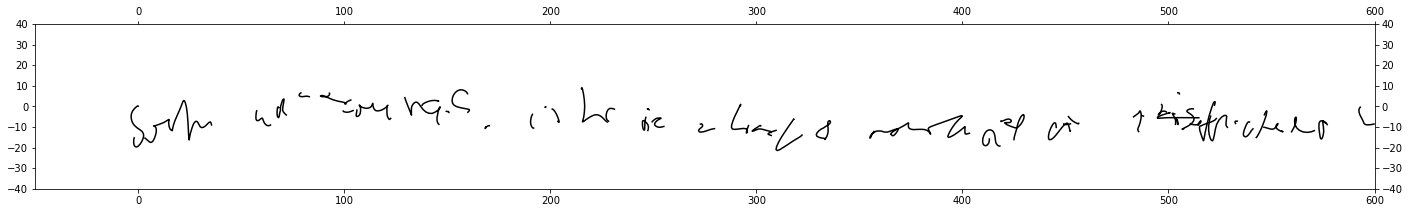

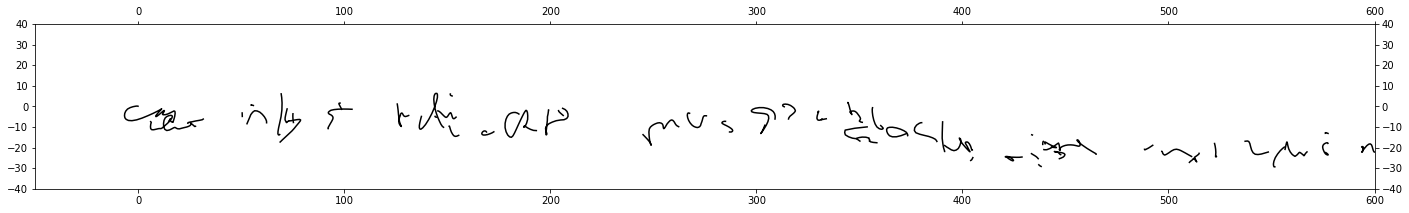

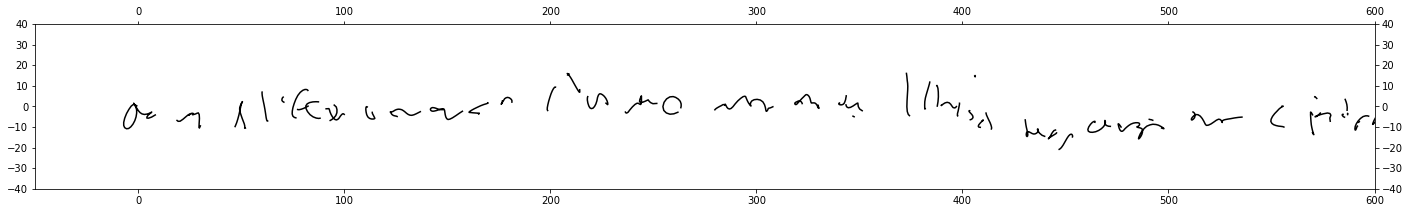

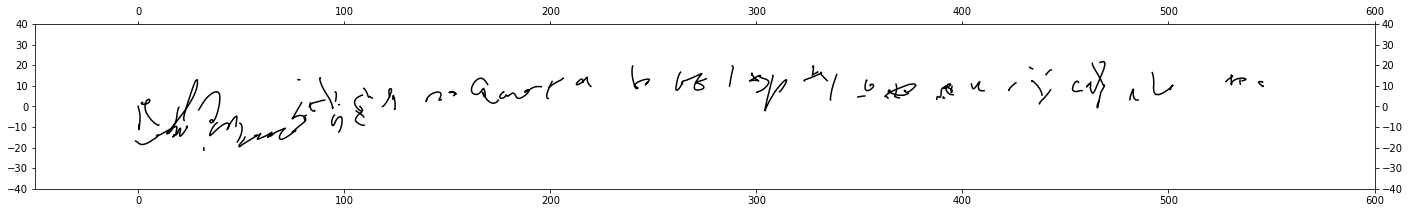

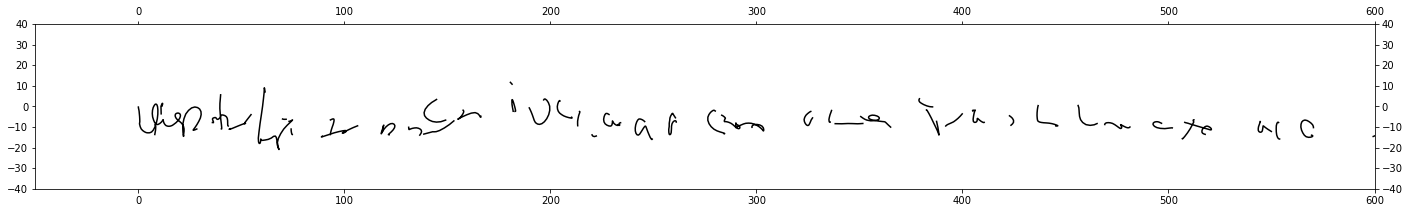

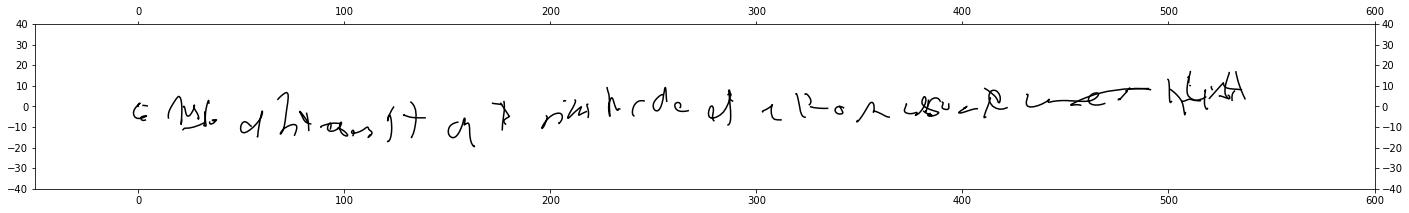

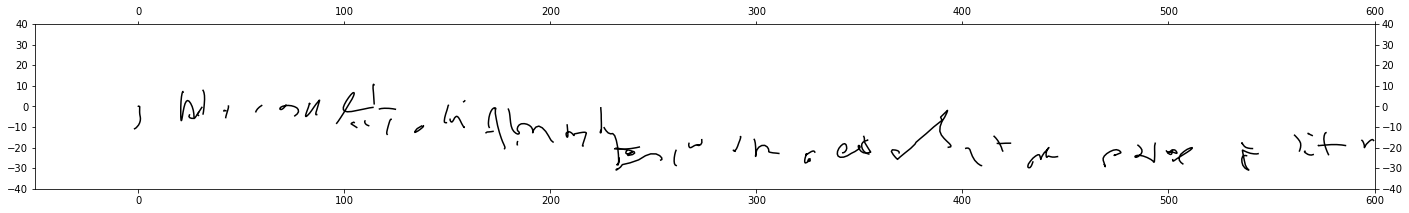

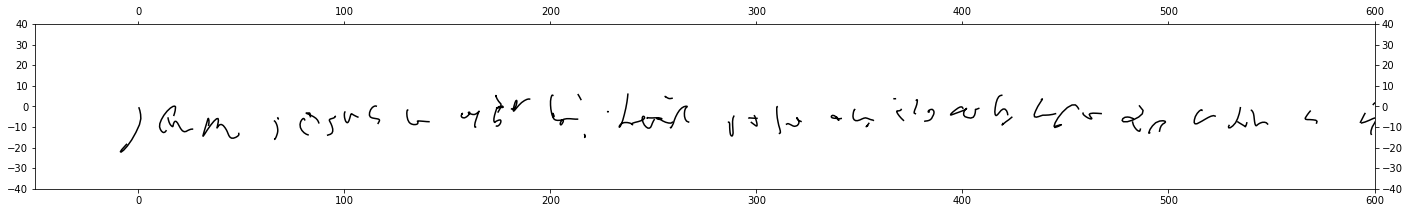

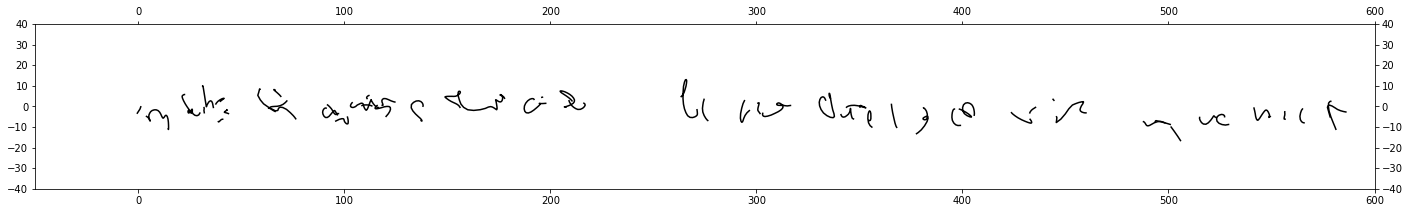

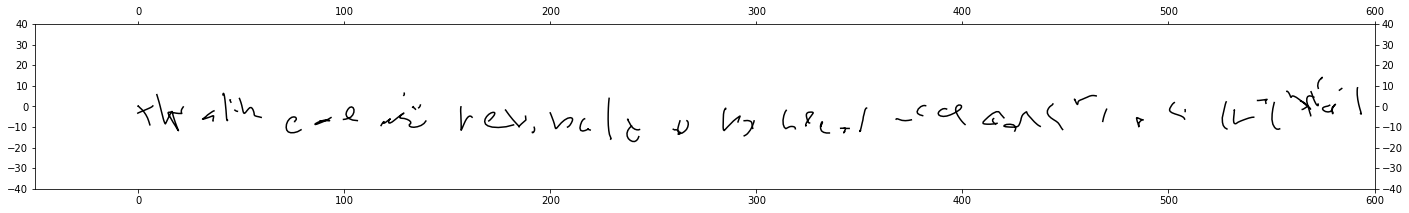

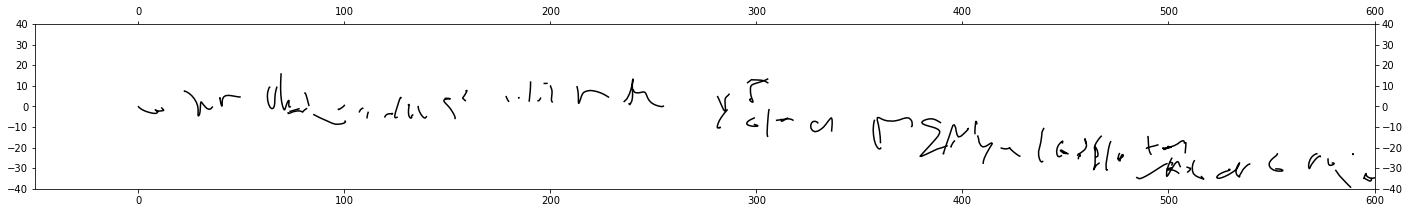

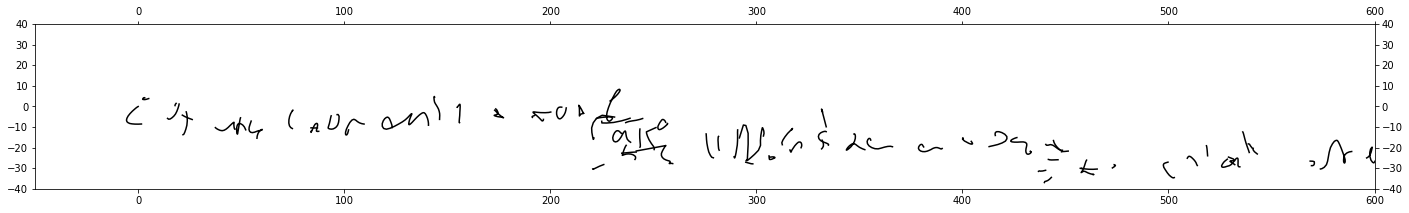

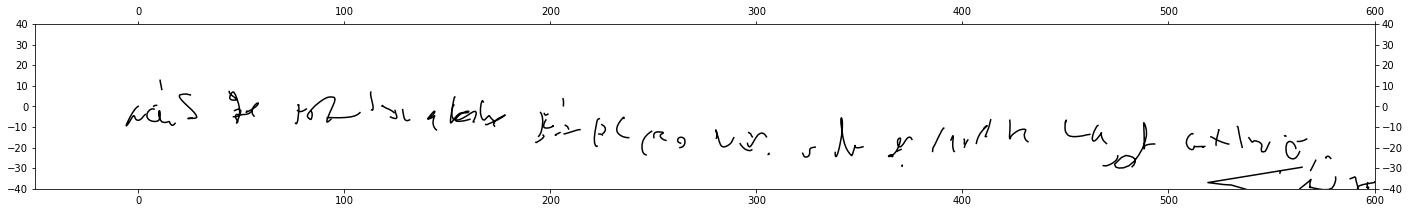

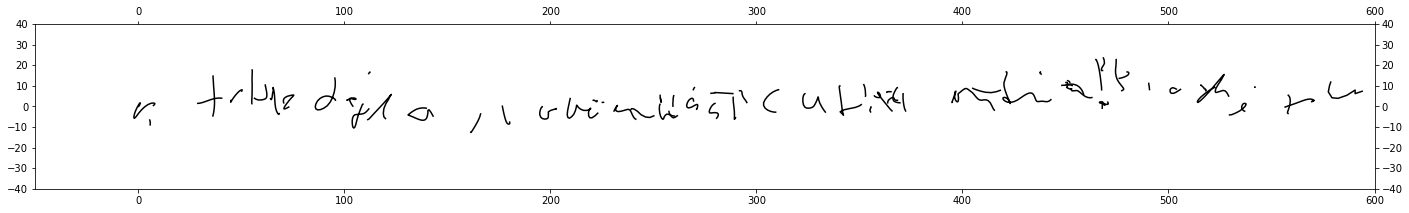

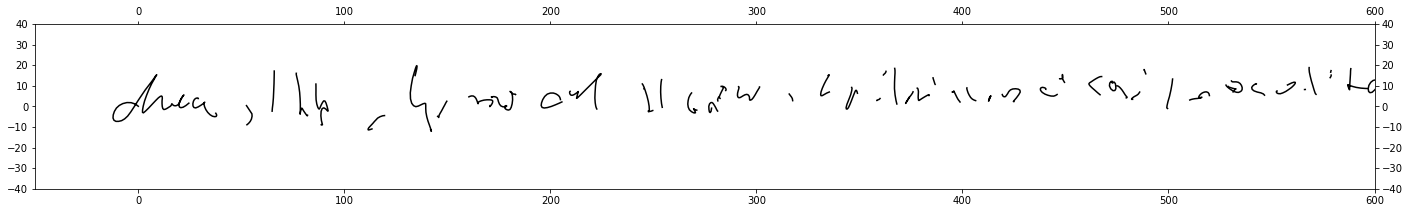

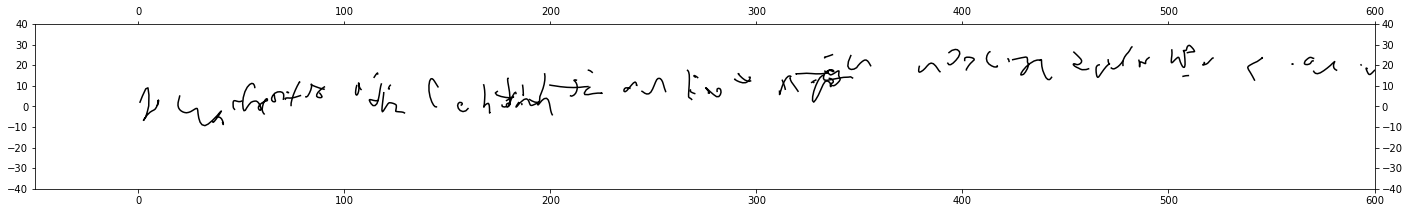

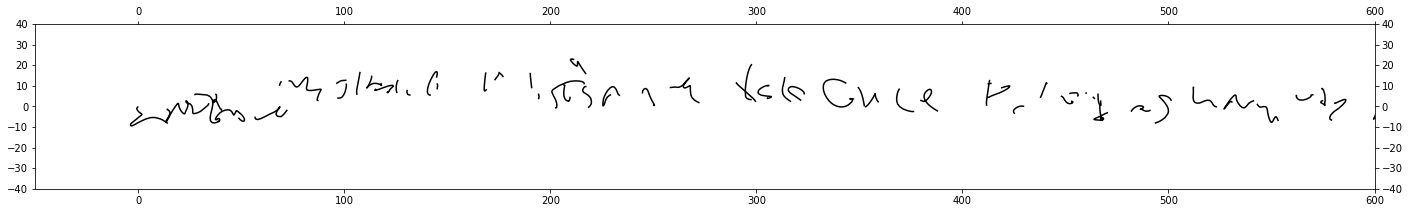

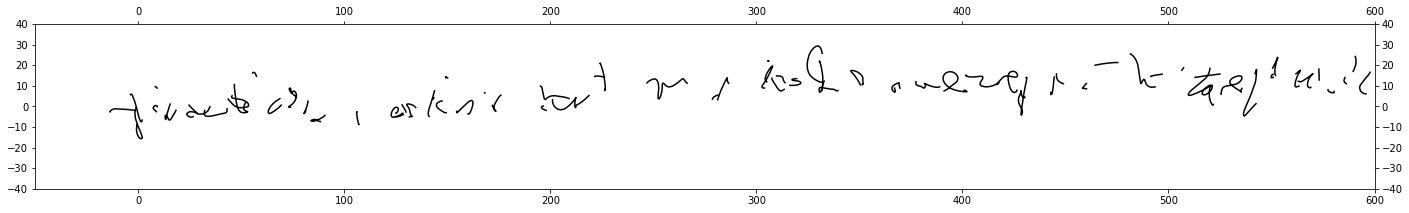

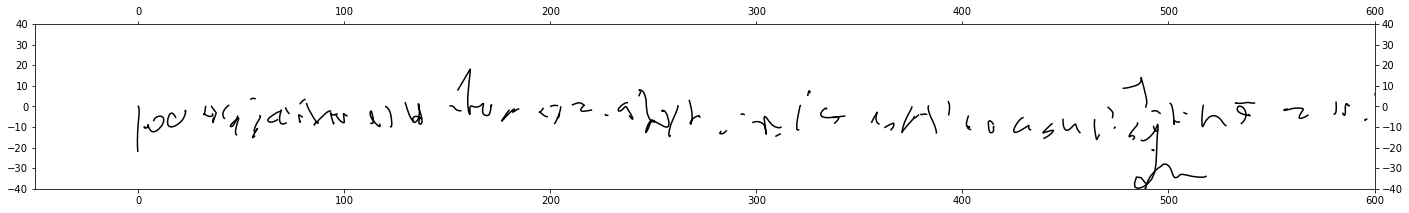

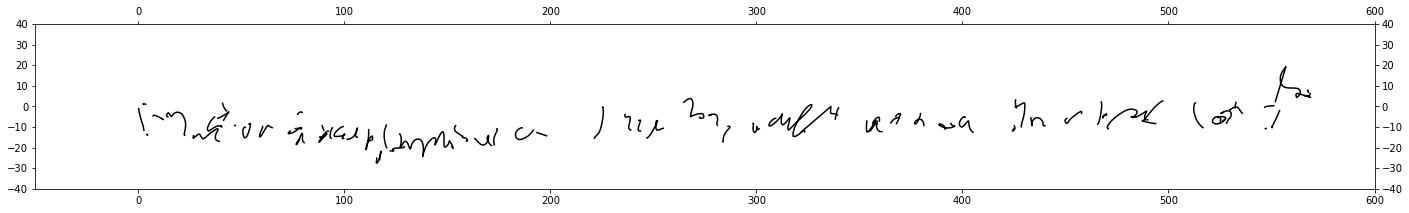

In [52]:
for i in range(20):
    sample_drawing()